# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, f1_score, accuracy_score,\
    classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import scatter_matrix
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)
data = data.dropna(subset=['TEAM_NAME'])
data.reset_index(drop=True,inplace=True)

Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

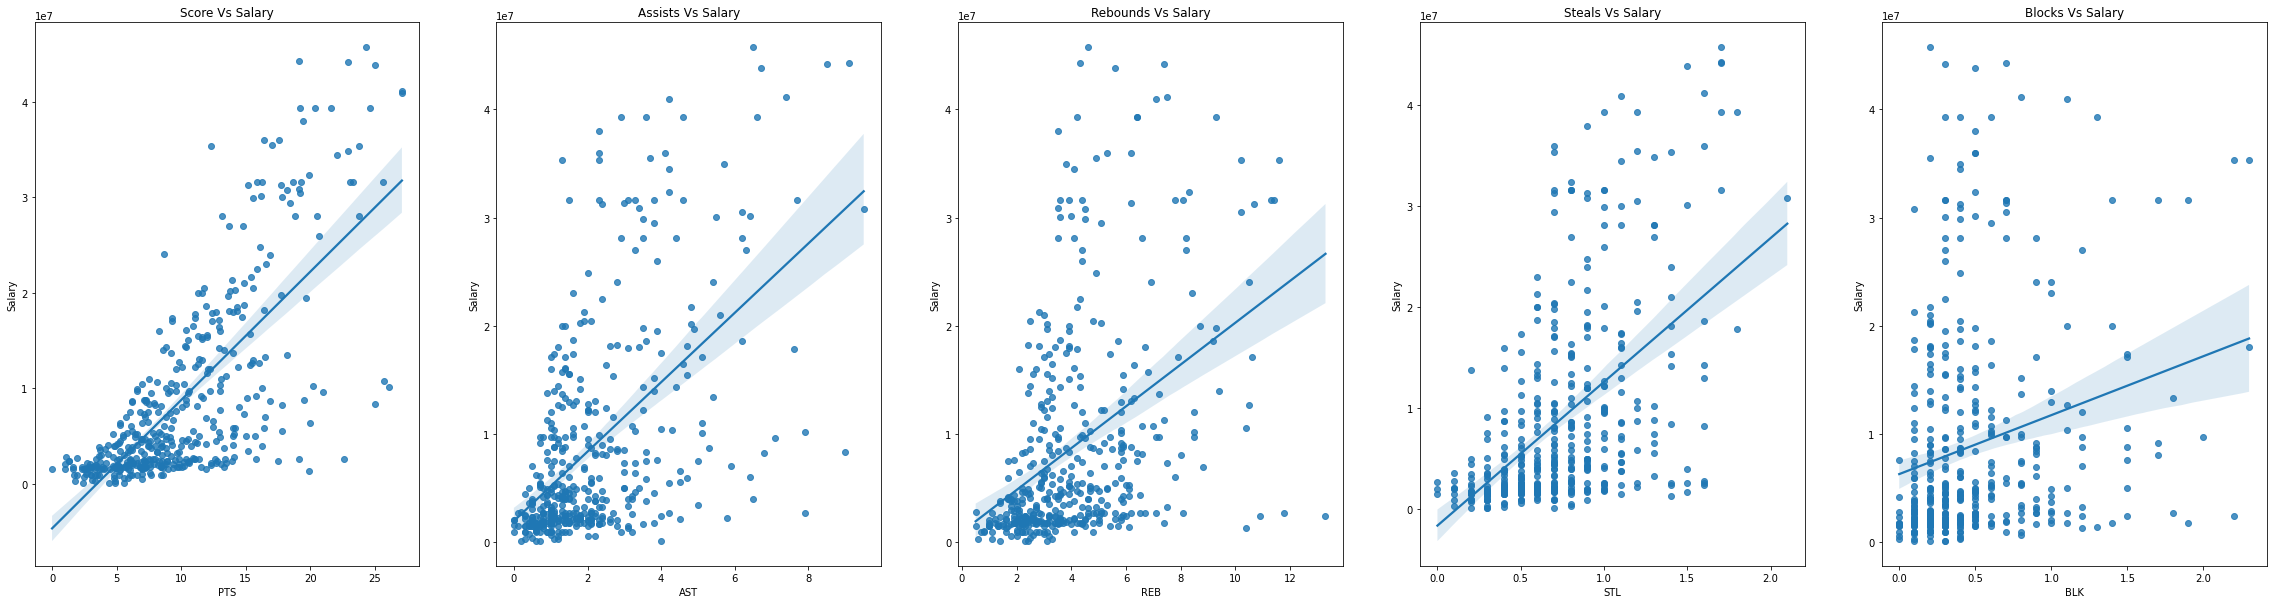

In [16]:
fig, axs = plt.subplots(ncols=5, figsize=(40,10))
sns.regplot(x='PTS', y='Salary', data=data, ax=axs[0]).set(title='Score Vs Salary')
sns.regplot(x='AST', y='Salary', data=data, ax=axs[1]).set(title='Assists Vs Salary')
sns.regplot(x='REB', y='Salary', data=data, ax=axs[2]).set(title='Rebounds Vs Salary')
sns.regplot(x='STL', y='Salary', data=data, ax=axs[3]).set(title='Steals Vs Salary')
sns.regplot(x='BLK', y='Salary', data=data, ax=axs[4]).set(title='Blocks Vs Salary')
plt.show()

1.2. What can we say about these distributions?

In [17]:
"""
Correlation seems not to be strong in any case.
The more promising attribute is Score. Even though, there are some outliers that should be treated.
In this particular case, they are explained by players with rookie contracts which may be having a great performance in PTS, but their salaries are capped.
"""

'\nCorrelation seems not to be strong in any case.\nThe more promising attribute is Score. Even though, there are some outliers that should be treated.\nIn this particular case, they are explained by players with rookie contracts which may be having a great performance in PTS, but their salaries are capped.\n'

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

<AxesSubplot:>

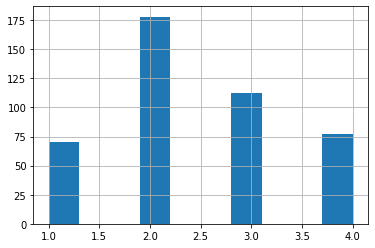

In [18]:
"""
We don't want just to create a random Test Set right off the bat since the dataset is very short.
Due to this, we could be incurring in sampling bias by not ensuring the test set is representative of the whole set.

In this sense, it would be desirable that Test set includes the whole spectrum of PTS, by Stratified Sampling.
As this is a continuous numerical attribute, it should be converted into clusters.
"""
players = data[['PTS', 'Salary']].copy()
players['PTS_cat'] = pd.cut(players['PTS'], bins=[0, 5, 10, 15, 30], labels=[1, 2, 3, 4], include_lowest=True)
players['PTS_cat'].hist()

In [19]:
# Stratified approach
players = players.reset_index(drop=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(players, players['PTS_cat']):
    strat_train_set = players.loc[train_index]
    strat_test_set = players.loc[test_index]

In [20]:
# Random approach
train_set, test_set = train_test_split(players, test_size=0.2, random_state=42)

In [21]:
# Sampling bias comparison
comp = pd.DataFrame({
    'Overall': players['PTS_cat'].value_counts() / len(players),
    'Stratified': strat_test_set['PTS_cat'].value_counts() / len(strat_test_set),
    'Random': test_set['PTS_cat'].value_counts() / len(test_set)
}).sort_index()
comp['Rand %error'] = ((comp['Random'] - comp['Overall']) / comp['Overall']) * 100
comp['Strat %error'] = ((comp['Stratified'] - comp['Overall']) / comp['Overall']) * 100
print(comp)

    Overall  Stratified    Random  Rand %error  Strat %error
1  0.160183    0.159091  0.204545    27.694805     -0.681818
2  0.407323    0.409091  0.386364    -5.145557      0.434116
3  0.256293    0.261364  0.295455    15.280032      1.978490
4  0.176201    0.170455  0.113636   -35.507674     -3.261511


In [22]:
# Removing Clustering to clean data again.
strat_train_set = strat_train_set.drop('PTS_cat', axis=1)
strat_test_set = strat_test_set.drop('PTS_cat', axis=1)
train_set = train_set.drop('PTS_cat', axis=1)
test_set = test_set.drop('PTS_cat', axis=1)

# Random and Stratified Train Sets
players = strat_train_set.drop('Salary', axis=1)
players_target = strat_train_set['Salary'].copy()
X_train = train_set.drop('Salary', axis=1)
y_train = train_set['Salary'].copy()

# Random and Stratified Test Sets
players_test = strat_test_set.drop('Salary', axis=1)
players_target_test = strat_test_set['Salary'].copy()
X_test = test_set.drop('Salary', axis=1)
y_test = test_set['Salary'].copy()

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [23]:
class BaselineModel():
    """A baseline model that always returns the same value, the mean of the players salary in the train data"""

    def fit(self, players_target):
        self.mean = int(np.mean(players_target))

    def predict(self, X):
        predictions = np.array([self.mean] * len(X.index))
        return (predictions)

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [24]:
model = BaselineModel()
model.fit(players_target)
baseline_prediction = model.predict(players_test)
baseline_error = mean_absolute_error(players_target_test, baseline_prediction)
baseline_error = int(round(baseline_error))
print(f"Baseline MAE is: {baseline_error}")

Baseline MAE is: 6304525


### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [25]:
# Feature Scaling
"""
Since there are no extreme outliers in PTS, using Min-Max Scaling seems the right fit.
"""
minmaxscal = MinMaxScaler()
players = minmaxscal.fit_transform(players.values.reshape(-1,1))
players_test = minmaxscal.fit_transform(players_test.values.reshape(-1,1))
X_train = minmaxscal.fit_transform(X_train.values.reshape(-1,1))
X_test = minmaxscal.fit_transform(X_test.values.reshape(-1,1))

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [26]:
# Testing & evaluating models

# Stratified approach
sgd_reg = SGDRegressor(random_state=42)
sgd_reg.fit(players, players_target.ravel())
sgd_predictions = sgd_reg.predict(players_test)
sgd_mse = mean_absolute_error(players_target_test, sgd_predictions)

# Random approach
sgd_regN = SGDRegressor(random_state=42)
sgd_regN.fit(X_train, y_train.ravel())
sgdN_predictions = sgd_regN.predict(X_test)
sgdN_mse = mean_absolute_error(y_test, sgdN_predictions)

print(f"SGDRegressor Error - Stratified: {sgd_mse}")
print(f"SGDRegressor Error - Random: {sgdN_mse}")

SGDRegressor Error - Stratified: 4628549.403952159
SGDRegressor Error - Random: 5338444.509410402


1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [30]:
def search_best_hyperparameters(train, train_targets, model, **kwargs):
    result = {
        "hyperparameters": None,
        "mae": None
    }
    # Complete your code here
    param_grid = [
        {str(key): value for key, value in kwargs.items()}
    ]
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_absolute_error', return_train_score=True)
    grid_search.fit(train, train_targets.ravel())

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    result.update({'hyperparameters': best_params, 'mae': best_score})

    return result

In [31]:
sgd_reg = SGDRegressor(random_state=42)
result = search_best_hyperparameters(players, players_target, sgd_reg, max_iter = [1000, 10000, 1000000],
                                     eta0 = [0.0001, 0.001, 0.01, 0.1])
best_params = result['hyperparameters']

C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improv

In [33]:
best_params

{'eta0': 0.0001, 'max_iter': 1000000}

In [34]:
best_params.update({'random_state':42})
def tuned_model_evaluation(X_train, y_train, X_test, y_test, model, params:dict):
    tuned_model = model(**{key:value for key, value in params.items()})
    tuned_model.fit(X_train, y_train)
    tuned_predictions = tuned_model.predict(X_test)
    best_mae = mean_absolute_error(y_test, tuned_predictions)

    return best_mae
best_mae = tuned_model_evaluation(players, players_target, players_test, players_target_test, SGDRegressor, best_params)

1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [40]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_error}")
print(f"SGDRegressor Error - Random: {sgdN_mse}")
print(f"Tuned SGDRegressor: {best_mae}")

Mean Absolute Error for each model:
Baseline: 6304525
SGDRegressor Error - Random: 5338444.509410402
Tuned SGDRegressor: 4684526.980898044


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [63]:
# Multivariate SGDRegressor

players_c = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "Salary", "PERSON_ID", "TEAM_NAME"]] .copy()
players_c = players_c.set_index('PERSON_ID')

#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [64]:
minmaxscal = MinMaxScaler()
columns = players_c[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]].values.reshape(-1, 5)
columns = minmaxscal.fit_transform(columns)
players_c[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = columns

players_c['DRAFT_NUMBER'] = players_c['DRAFT_NUMBER'].replace('Undrafted', 0)
players_c['DRAFT_NUMBER'] = (players_c['DRAFT_NUMBER'].fillna(0)).astype('int64')
players_c['draf_bin'] = pd.cut(players_c['DRAFT_NUMBER'],
                               bins=[0, 15, 30, 60, 100], include_lowest=True, labels=['firstround_lottery',
                                                                       'firstround_non_lottery',
                                                                       'second_round',
                                                                       'undrafted'])

In [65]:
players_c.head()


,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,TEAM_NAME,draf_bin
PERSON_ID,,,,,,,,,,
1630173,0.239852,0.359375,0.084211,0.217391,0.055556,Forward,20,2711280,Raptors,firstround_non_lottery
203500,0.343173,0.578125,0.147368,0.391304,0.444444,Center,12,17073171,Grizzlies,firstround_lottery
1628389,0.487085,0.601562,0.368421,0.391304,0.222222,Center,14,28103550,Heat,firstround_lottery
1630583,0.121771,0.148438,0.052632,0.130435,0.000000,Forward,30,1994520,Grizzlies,firstround_non_lottery
200746,0.704797,0.593750,0.200000,0.478261,0.833333,Center,2,2641691,Nets,firstround_lottery


1.12. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [66]:
players_c = pd.get_dummies(players_c, columns=['draf_bin', 'POSITION', 'TEAM_NAME'])

In [67]:
players_c.head()

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_NUMBER,Salary,draf_bin_firstround_lottery,draf_bin_firstround_non_lottery,draf_bin_second_round,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1630173,0.239852,0.359375,0.084211,0.217391,0.055556,20,2711280,0,1,0,...,0,1,0,0,0,0,0,0,0,0
203500,0.343173,0.578125,0.147368,0.391304,0.444444,12,17073171,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1628389,0.487085,0.601562,0.368421,0.391304,0.222222,14,28103550,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1630583,0.121771,0.148438,0.052632,0.130435,0.000000,30,1994520,0,1,0,...,0,0,0,0,0,0,0,0,0,0
200746,0.704797,0.593750,0.200000,0.478261,0.833333,2,2641691,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

1.13. Split the dataset into train and test

In [68]:
players_x = players_c.drop(['Salary', 'DRAFT_NUMBER'], axis=1)
players_y = players_c['Salary'].copy()
X_train, X_test, y_train, y_test = train_test_split(players_x, players_y, test_size=0.2, random_state=42)

1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [ ]:
"""
Already done above.
"""

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [69]:
sgd_reg_multi = SGDRegressor(random_state=42)
result2 = search_best_hyperparameters(X_train, y_train, sgd_reg_multi,
                                      loss = ['squared_loss', 'squared_epsilon_insensitive', 'huber', 'epsilon_insensitive'],
                                      penalty = ['l1', 'l2', 'elasticnet'],
                                      max_iter = [100, 500, 1000])
best_params2 = result2['hyperparameters']

C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence

1.16. How did the model performed compared to our univariate models?

In [70]:
best_params2.update({'random_state':42})
best_mae_multi = tuned_model_evaluation(X_train, y_train, X_test, y_test, SGDRegressor, best_params2)
print(f'Multi SGDRegressor Error: {best_mae_multi}')

"""
Model with Stratified Sampling seems to be doing slightly better than a Multivariate regression with Random approach.
"""

Multi SGDRegressor Error: 4725051.541373524


'\nModel with Stratified Sampling seems to be doing slightly better than a Multivariate regression with Random approach.\n'

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [71]:
dec_tree = DecisionTreeRegressor(random_state=42)
result3 = search_best_hyperparameters(X_train, y_train, dec_tree, max_depth = [5, 10, 15, 20, 50],
                                      min_samples_leaf = [2, 10, 20, 50], max_features = [5, 10])
best_params3 = result3['hyperparameters']

1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [72]:
best_params3.update({'random_state':42})
best_mae_multi_dt = tuned_model_evaluation(X_train, y_train, X_test, y_test, DecisionTreeRegressor, best_params3)
print(f'Multi Decision Tree Error: {best_mae_multi_dt}')

Multi Decision Tree Error: 4635161.03464795


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

In [ ]:
"""
Now there's a clear improvement in the result with the Decision Tree.
This means that a non-linear approach was the right fit due to the Draft variable that "spoils" the linear correlation
of the rest of players.
"""

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

In [ ]:
"""
Maybe we could run a linear model for non-rookie players and a non-linear model for rookie ones, to improve results.
"""

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [74]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv"
                         , index_col=0)
all_nba_df = all_nba_df.reset_index(drop=True)
print(f"Number of rows: {len(all_nba_df)}")
print(f"Number of seasons: {all_nba_df['season_id'].nunique()}")
print(f"Number of players: {all_nba_df['player_id'].nunique()}")
print(f"Number of all-nba selections: {len(all_nba_df[all_nba_df['all_nba']==1])}")
print(f"Number of non-selected: {len(all_nba_df[all_nba_df['all_nba']==0])}")

Number of rows: 14825
Number of seasons: 14825
Number of players: 2718
Number of all-nba selections: 496
Number of non-selected: 14329


### Splitting the dataset

In [75]:
players_x = all_nba_df.drop(['all_nba', 'season_id', 'player_id', 'player_season', 'player', 'season', 'season_start'], axis=1)
players_y = all_nba_df['all_nba'].copy()
X_train, X_test, y_train, y_test = train_test_split(players_x, players_y,
                                                    random_state=42, stratify=all_nba_df['all_nba'])

comp = pd.DataFrame({'Overall': all_nba_df['all_nba'].value_counts() / len(all_nba_df),
                    'Stratified': y_test.value_counts() / len(y_test)}).sort_index()
comp

,Overall,Stratified
0,0.966543,0.96655
1,0.033457,0.03345


2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'



### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [ ]:
class BaseLineModel():
    def fit(self, xtrain, ytrain):
        return self

    def predict(self, X):
        predictions = np.zeros((len(X), 1))
        return predictions

In [76]:
model = BaseLineModel()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
baseline_error = mean_absolute_error(y_test, predictions)
baseline_accuracy = accuracy_score(y_test, predictions)
print('---------------------------------------------------------------------')
print(f"Baseline model Accuracy: {baseline_accuracy}")

---------------------------------------------------------------------
Baseline model Accuracy: 0.9665497707040733


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In [ ]:
"""
In general, accuracy is not the only metric we should look at, since it may be misleading.
In this particular case, we have a class imbalance. Accuracy is not a good metric to evaluate model performance.

We could resample data in order to improve the imbalance.
Also, using another metric such as F1 which is a better fit, since it measures also the type of error made.
"""

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [ ]:
# Function to Scale only numerical features from a given dataset, using a given Scaling method.
def numerical_scaler(features_df, scaling_method):
    columns_drop_list = []
    features_df = features_df.reset_index(drop=True)
    for column in features_df:
        if features_df[str(column)].dtypes in ['float', 'float64', 'int64']:
            pass
        else:
            columns_drop_list.append(column)

    num_attr = features_df.drop(columns_drop_list, axis=1)
    num_attr_columns = num_attr.columns
    scaler = scaling_method
    num_attr = pd.DataFrame(scaler.fit_transform(num_attr), columns=num_attr_columns)
    num_attr = num_attr.reset_index(drop=True)
    features_df = pd.concat([features_df[columns_drop_list], num_attr], axis=1)

    return features_df

In [77]:
players_x = numerical_scaler(players_x, StandardScaler())
players_x.head()

,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
0,POR,-0.445940,-0.880050,-1.332515,0.367527,-1.166018,0.150580,-0.707704,-0.574478,-0.837580,-1.193239,-0.235911,-0.925767,-1.218505,-0.858149
1,POR,0.662973,-0.846289,-0.698830,0.568822,-1.166018,0.341439,0.279367,0.049591,-0.784280,-0.570199,-0.430610,-0.435572,-0.045968,-0.358968
2,TOT,0.821389,0.875513,-0.279622,0.833685,-1.166018,0.602615,0.316918,0.361626,-0.784280,-0.777879,-0.235911,0.054624,0.657554,-0.092738
3,BOS,-1.634062,-0.880050,-0.796320,-0.035064,-1.166018,-0.231138,-0.321459,-0.028417,-0.890881,-0.985559,-0.430610,0.054624,-0.514983,-0.558641
4,TOT,-0.010296,-0.880050,-1.069292,0.759523,-1.166018,0.562434,-0.691611,-0.574478,-0.890881,-0.777879,-0.430610,-0.558121,-0.045968,-0.591919


2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [78]:
log_reg = LogisticRegression(random_state=42)
players_x2 = players_x.drop('team', axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(players_x2, players_y,
                                                    random_state=42, stratify=all_nba_df['all_nba'])
log_reg.fit(X_train2, y_train2)
log_reg_baseline_pred = log_reg.predict(X_test2)

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [79]:
logreg_base_acc = accuracy_score(y_test2, log_reg_baseline_pred)
logreg_base_prec = precision_score(y_test2, log_reg_baseline_pred)
logreg_base_recall = recall_score(y_test2, log_reg_baseline_pred)
logreg_base_f1 = f1_score(y_test2, log_reg_baseline_pred)

print('---------------------------------------------------------------------')
print(f"Accuracy: {logreg_base_acc}")
print(f"Precision: {logreg_base_prec}")
print(f"Recall: {logreg_base_recall}")
print(f"F1: {logreg_base_f1}")

---------------------------------------------------------------------
Accuracy: 0.9797680064742379
Precision: 0.7634408602150538
Recall: 0.5725806451612904
F1: 0.6543778801843319


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [ ]:
def encode_df(features_df, column_tobe_encoded: str):
    encode = OneHotEncoder()
    enc_df = pd.DataFrame(encode.fit_transform(features_df[[column_tobe_encoded]]).toarray())
    enc_df.columns = encode.get_feature_names_out([column_tobe_encoded])
    enc_df.columns = enc_df.columns.str.replace(column_tobe_encoded+'_', '')
    features_df = features_df.reset_index(drop=True)
    features_df = features_df.drop(column_tobe_encoded, axis=1)
    features_df = pd.concat([features_df, enc_df], axis=1)

    return features_df

In [80]:
players_x = encode_df(players_x, 'team')
players_x.head()

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SAC,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB
0,-0.445940,-0.880050,-1.332515,0.367527,-1.166018,0.150580,-0.707704,-0.574478,-0.837580,-1.193239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.662973,-0.846289,-0.698830,0.568822,-1.166018,0.341439,0.279367,0.049591,-0.784280,-0.570199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.821389,0.875513,-0.279622,0.833685,-1.166018,0.602615,0.316918,0.361626,-0.784280,-0.777879,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.634062,-0.880050,-0.796320,-0.035064,-1.166018,-0.231138,-0.321459,-0.028417,-0.890881,-0.985559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.010296,-0.880050,-1.069292,0.759523,-1.166018,0.562434,-0.691611,-0.574478,-0.890881,-0.777879,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(players_x, players_y,
                                                    random_state=42, stratify=all_nba_df['all_nba'])
log_reg = LogisticRegression(random_state=42)
result4 = search_best_hyperparameters(X_train, y_train, log_reg, tol=[0.00001, 0.0001, 0.001, 0.01],
                                     C=[0.001,0.01,0.1,1,10,100], max_iter=[100, 1000, 10000, 100000])
best_params4 = result4['hyperparameters']
best_params4.update({'random_state':42})

C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [85]:
def tuned_model_evaluation(X_train, y_train, X_test, y_test, model, params:dict):
    tuned_model = model(**{key:value for key, value in params.items()})
    tuned_model.fit(X_train, y_train)
    tuned_predictions = tuned_model.predict(X_test)
    tuned_f1 = f1_score(y_test, tuned_predictions)
    tuned_recall = recall_score(y_test, tuned_predictions)
    tuned_precision = precision_score(y_test, tuned_predictions)

    return tuned_recall, tuned_precision, tuned_f1, tuned_predictions, tuned_model

In [86]:
log_reg_tuned = tuned_model_evaluation(X_train, y_train, X_test, y_test, LogisticRegression, best_params4)
log_reg_tuned_precision = log_reg_tuned[1]
log_reg_tuned_recall = log_reg_tuned[0]
log_reg_tuned_f1 = log_reg_tuned[2]
log_reg_tuned_predictions = log_reg_tuned[3]

print('---------------------------------------------------------------------')
print(f"Precision Tuned Log Reg: {log_reg_tuned_precision}")
print(f"Recall Tuned Log Reg: {log_reg_tuned_recall}")
print(f"F1 Tuned Log Reg: {log_reg_tuned_f1}")

---------------------------------------------------------------------
Precision Tuned Log Reg: 0.8181818181818182
Recall Tuned Log Reg: 0.5806451612903226
F1 Tuned Log Reg: 0.679245283018868


C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [88]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
def add_missing_teams(complete_df, incomplete_df):
    missing_columns = []
    for column in complete_df:
        if column in incomplete_df.columns:
            pass
        else:
            missing_columns.append(column)

    incomplete_df[[missing_columns]] = float(0)

    return incomplete_df

In [89]:
all_nba_2018_df = all_nba_2018_df.iloc[:, 6:]
all_nba_2018_df = numerical_scaler(all_nba_2018_df, StandardScaler())
all_nba_2018_df = encode_df(all_nba_2018_df, 'team')
all_nba_2018_df = add_missing_teams(players_x, all_nba_2018_df)

X_test_2018 = all_nba_2018_df
y_test_2018 = all_nba_2018_selections['all_nba'].copy()
y_test_2018 = y_test_2018.reset_index(drop=True)

2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [91]:
new_test_log_reg = tuned_model_evaluation(X_train, y_train, all_nba_2018_df, y_test_2018, LogisticRegression, best_params4)
new_test_recall = new_test_log_reg[0]
new_test_precision = new_test_log_reg[1]
new_test_f1 = new_test_log_reg[2]
new_test_predictions = new_test_log_reg[3]
log_reg_model = new_test_log_reg[4]

print('---------------------------------------------------------------------')
print(classification_report(y_test_2018, new_test_predictions))

---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       515
           1       0.65      0.87      0.74        15

    accuracy                           0.98       530
   macro avg       0.82      0.93      0.87       530
weighted avg       0.99      0.98      0.98       530



C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


2.12. Analyze the results, what do you think it is happening?

In [ ]:
"""
With a set with higher percentage of positives, the Precision is higher and the Recall lower.
While when the positives percentage is low, the Precision is much lower and Recall much higher.

So, in the first case, the cases where the model predicted positive, it was really positive but failed to find them all.
In the second case, the model predicted most of the positives but also returned a high percentage of false positives.

In other words, the model is prone to predicting false positives.
"""

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [92]:
prob = log_reg_model.predict_proba(all_nba_2018_df)[:,1]

all_nba_2018_predictions = log_reg_model.predict(all_nba_2018_df)
all_nba_2018_selections = all_nba_2018_selections.reset_index(drop=True)
all_nba_2018_selections['Prediction'] = all_nba_2018_predictions
all_nba_2018_selections['all_nba_prob'] = prob
all_nba_2018_selections['all_nba_prob'] = all_nba_2018_selections['all_nba_prob'].round(3)
all_nba_2018_selections.head()

C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,player_id,player,all_nba,Prediction,all_nba_prob
0,5,Alex Abrines,0,0,0.000
1,8,Quincy Acy,0,0,0.000
2,10,Jaylen Adams,0,0,0.000
3,13,Steven Adams,0,0,0.009
4,15,Bam Adebayo,0,0,0.000


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [93]:
all_nba_2018_selections = all_nba_2018_selections.sort_values('all_nba_prob', ascending=False)
all_nba_2018_selections.head(15)

,player_id,player,all_nba,Prediction,all_nba_prob
17,83,Giannis Antetokounmpo,1,1,0.999
205,1024,James Harden,1,1,0.999
125,587,Anthony Davis,0,1,0.997
257,1240,LeBron James,1,1,0.996
154,740,Joel Embiid,1,1,0.973
491,2572,Nikola Vucevic,0,1,0.919
300,1492,Kawhi Leonard,1,1,0.914
505,2648,Russell Westbrook,1,1,0.908
149,695,Kevin Durant,1,1,0.864
479,2501,Karl-Anthony Towns,0,1,0.846


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [98]:
true_positive_selection = all_nba_2018_selections[(all_nba_2018_selections['all_nba']==1) &
                                                  (all_nba_2018_selections['Prediction']==1)]['player']
true_negative_selection = all_nba_2018_selections[(all_nba_2018_selections['all_nba']==1) &
                                                  (all_nba_2018_selections['Prediction']==0)]['player']
false_positive_selection = all_nba_2018_selections[(all_nba_2018_selections['all_nba']==0) &
                                                   (all_nba_2018_selections['Prediction']==1)]['player']

print(f"True Positive players:")
print(true_positive_selection)
print('---------------------------------------------------------------------')
print(f"True Negative players:")
print(true_negative_selection)
print('---------------------------------------------------------------------')
print(f"False Positive players:")
print(false_positive_selection)

True Positive players:
17     Giannis Antetokounmpo
205             James Harden
257             LeBron James
154              Joel Embiid
300            Kawhi Leonard
505        Russell Westbrook
149             Kevin Durant
268             Nikola Jokic
495             Kemba Walker
182              Paul George
186              Rudy Gobert
248             Kyrie Irving
304           Damian Lillard
Name: player, dtype: object
---------------------------------------------------------------------
True Negative players:
123    Stephen Curry
201    Blake Griffin
Name: player, dtype: object
---------------------------------------------------------------------
False Positive players:
125         Anthony Davis
491        Nikola Vucevic
479    Karl-Anthony Towns
229          Jrue Holiday
39           Bradley Beal
88           Clint Capela
7       LaMarcus Aldridge
Name: player, dtype: object


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [100]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        self._model = model

    def predict(self, df_features: pd.DataFrame):
        prob = self._model.predict_proba(df_features)[:,1]
        df_features['prob'] = prob
        df_features = df_features.sort_values('prob', ascending=False)
        df_features['prediction'] = 0
        df_features.iloc[0:15, -1] = 1
        predictions = df_features['prediction'].sort_index(ascending=True).to_numpy()
        return predictions

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [101]:
last_model = AllNbaSingleSeasonClassifier(log_reg_model)
last_model_predictions = last_model.predict(all_nba_2018_df)
last_model_f1 = f1_score(y_test_2018, last_model_predictions)
last_model_recall = recall_score(y_test_2018, last_model_predictions)
last_model_precision = precision_score(y_test_2018, last_model_predictions)
print('---------------------------------------------------------------------')
print(f"Precision Last Log Reg - New Test Set: {last_model_precision}")
print(f"Recall Last Log Reg - New Test Set: {last_model_recall}")
print(f"F1 Last Log Reg - New Test Set: {last_model_f1}")

---------------------------------------------------------------------
Precision Last Log Reg - New Test Set: 0.7333333333333333
Recall Last Log Reg - New Test Set: 0.7333333333333333
F1 Last Log Reg - New Test Set: 0.7333333333333333


C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

In [ ]:
"""
The Data Set is highly imbalanced.
"""

2.19. What do you think we could do to improve our model?

In [ ]:
"""
Fixin Data imbalance.
Dumping features that do not contribute as much to the results.
Or experimenting with attribute combinations instead of using them just the way they are. Maybe by weighting "PTS" / "STL" / "BLK", etc...
by player's position.
"""

### Optional: Oversampling

In [ ]:
"""
I'll try to do the optionals anyways by the end of this week but I wanted to deliver ontime.
"""